## Ignore this notebook, I used it to scribble!

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/Sales.csv")

In [3]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [4]:
df.isna().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [5]:
df = df.dropna().reset_index(drop=True)
temp_df = pd.DataFrame(columns=['date_column'])

one_dates_list = list(df['Order Date'].unique()) + list(df['Ship Date'].unique())
temp_df['date_column'] = one_dates_list
temp_df

In [7]:
temp_df['date_column'] = pd.to_datetime(temp_df["date_column"], format="mixed")
df['Order Date'] = pd.to_datetime(df["Order Date"], format="mixed")

In [9]:
date_dimension = pd.DataFrame({
    "Full_Date": temp_df["date_column"],
    "Year": temp_df["date_column"].dt.year,
    "Quarter": temp_df["date_column"].dt.quarter,
    "Month": temp_df["date_column"].dt.month,
    "Week": temp_df["date_column"].dt.isocalendar().week,
    "Day_Of_Week": temp_df["date_column"].dt.day_name(),
}).drop_duplicates().reset_index(drop=True)

# Customer Dimension Table
customer_dimension = df[["Customer ID", "Customer Name", "Segment"]].drop_duplicates().reset_index(drop=True)
customer_dimension.rename(columns={
    "Customer ID": "Customer_ID",
    "Customer Name": "Customer_Name"
}, inplace=True)

# Product Dimension Table
product_dimension = df[["Product ID", "Product Name", "Category", "Sub-Category"]].drop_duplicates().reset_index(drop=True)
product_dimension.rename(columns={
    "Product ID": "Product_ID",
    "Product Name": "Product_Name",
    "Sub-Category": "Sub_Category"
}, inplace=True)

# Location Dimension Table
location_dimension = df[["Country", "Region", "State", "City", "Postal Code"]].drop_duplicates().reset_index(drop=True)
location_dimension.rename(columns={"Postal Code": "Postal_Code"}, inplace=True)

# Ship Mode Dimension Table
ship_mode_dimension = df[["Ship Mode"]].drop_duplicates().reset_index(drop=True)
ship_mode_dimension.rename(columns={"Ship Mode": "Ship_Mode"}, inplace=True)

# # Sales Fact Table
sales_fact = pd.DataFrame({
    "Order_ID": df["Order ID"],
    "Date_Key": pd.factorize(df["Order Date"])[0] + 1,
    "Ship_Date_Key": pd.factorize(df["Ship Date"])[0] + 1,
    "Customer_Key": pd.factorize(df["Customer ID"])[0] + 1,
    "Product_Key": pd.factorize(df["Product ID"])[0] + 1,
    "Location_Key": pd.factorize(df["City"] + df["State"] + df["Postal Code"].astype(str))[0] + 1,
    "Ship_Mode_Key": pd.factorize(df["Ship Mode"])[0] + 1,
    "Sales": df["Sales"],
})

In [1]:
import mysql.connector

# Database connection
def get_connection():
    return mysql.connector.connect(
        host="localhost",
        user="admin",
        password="admin",
        database="salesdb",
    )

connection = get_connection()
cursor = connection.cursor(buffered=True)

In [ ]:
def load_df_to_table(query: str, df: pd.DataFrame):
    # Prepare data for insertion
    data_to_insert = df.values.tolist()

    # Execute the query using executemany
    cursor.executemany(query, data_to_insert)
    connection.commit()
    print("Done!")

dfs_list = [
    date_dimension, customer_dimension, product_dimension, 
    location_dimension, ship_mode_dimension
]


insert_queries_list = [
    """
        INSERT INTO Date_Dimension (Full_Date, Year, Quarter, Month, Week, Day_Of_Week)
        VALUES (%s, %s, %s, %s, %s, %s)
    """,
    """
        INSERT INTO Customer_Dimension (Customer_ID, Customer_Name, Segment)
        VALUES (%s, %s, %s)
    """,
    """
        INSERT INTO Product_Dimension (Product_ID, Product_Name, Category, Sub_Category)
        VALUES (%s, %s, %s, %s)
    """,
    """
        INSERT INTO Location_Dimension (Country, Region, State, City, Postal_Code)
        VALUES (%s, %s, %s, %s, %s)
    """,
    """
        INSERT INTO Ship_Mode_Dimension (Ship_Mode)
        VALUES (%s)
    """
]

# dimenions
for query, df_ in zip(insert_queries_list, dfs_list):
    load_df_to_table(query, df_)

Done!
Done!
Done!
Done!
Done!


In [11]:
df["Order Date"] = pd.to_datetime(df["Order Date"]).dt.strftime('%Y-%m-%d')
df["Ship Date"] = pd.to_datetime(df["Ship Date"], format="mixed").dt.strftime('%Y-%m-%d')

In [13]:
sales_facts_ahmad = df[['Order ID', 'Order Date', 'Ship Date', 'Customer ID', 'Product ID',
       'Postal Code', 'Ship Mode', 'Sales']].drop_duplicates()

sales_facts_ahmad

,Order ID,Order Date,Ship Date,Customer ID,Product ID,Postal Code,Ship Mode,Sales
0,CA-2017-152156,2017-08-11,2017-11-11,CG-12520,FUR-BO-10001798,42420.0,Second Class,261.9600
1,CA-2017-152156,2017-08-11,2017-11-11,CG-12520,FUR-CH-10000454,42420.0,Second Class,731.9400
2,CA-2017-138688,2017-12-06,2017-06-16,DV-13045,OFF-LA-10000240,90036.0,Second Class,14.6200
3,US-2016-108966,2016-11-10,2016-10-18,SO-20335,FUR-TA-10000577,33311.0,Standard Class,957.5775
4,US-2016-108966,2016-11-10,2016-10-18,SO-20335,OFF-ST-10000760,33311.0,Standard Class,22.3680
...,...,...,...,...,...,...,...,...
9784,CA-2017-125920,2017-05-21,2017-05-28,SH-19975,OFF-BI-10003429,60610.0,Standard Class,3.7980
9785,CA-2016-128608,2016-12-01,2016-01-17,CS-12490,OFF-AR-10001374,43615.0,Standard Class,10.3680
9786,CA-2016-128608,2016-12-01,2016-01-17,CS-12490,TEC-PH-10004977,43615.0,Standard Class,235.1880
9787,CA-2016-128608,2016-12-01,2016-01-17,CS-12490,TEC-PH-10000912,43615.0,Standard Class,26.3760


In [15]:
raw_sales_fact_data = sales_facts_ahmad.values.tolist()

In [14]:
def fetch_dimension_key(cursor, table, key_column, lookup_column, value):
    """
    Fetch the primary key of a dimension record. If it doesn't exist, insert it and fetch the new key.
    """
    cursor.execute(f"SELECT {key_column} FROM {table} WHERE {lookup_column} = %s", (value,))
    result = cursor.fetchone()
    if result:
        return result[0]
    else:
        # Insert new record and fetch the new key
        cursor.execute(f"INSERT INTO {table} ({lookup_column}) VALUES (%s) RETURNING {key_column}", (value,))
        return cursor.fetchone()[0]


def transform_sales_data(cursor, sales_data):
    """
    Transform raw sales data (2D list) by replacing dimension values with foreign keys.
    """
    transformed_data = []
    failed = 0
    for record in sales_data:
        try:
            order_id = record[0]
            order_date = fetch_dimension_key(cursor, "Date_Dimension", "Date_Key", "Full_Date", record[1])
            ship_date = fetch_dimension_key(cursor, "Date_Dimension", "Date_Key", "Full_Date", record[2])
            customer_key = fetch_dimension_key(cursor, "Customer_Dimension", "Customer_Key", "Customer_ID", record[3])
            product_key = fetch_dimension_key(cursor, "Product_Dimension", "Product_Key", "Product_ID", record[4])
            location_key = fetch_dimension_key(cursor, "Location_Dimension", "Location_Key", "Postal_Code", record[5])
            ship_mode_key = fetch_dimension_key(cursor, "Ship_Mode_Dimension", "Ship_Mode_Key", "Ship_Mode", record[6])
            sales = record[7]

            # Append the transformed record
            transformed_data.append(
                (order_id, order_date, ship_date, customer_key, product_key, location_key, ship_mode_key, sales)
            )
        except:
            failed += 1
    print(f"Number of failed records: {failed}")
    return transformed_data


def insert_fact_table(cursor, fact_table, transformed_data):
    """
    Insert transformed data into the fact table.
    """
    cursor.executemany(f"""
        INSERT INTO {fact_table} 
        (Order_ID, Date_Key, Ship_Date_Key, Customer_Key, Product_Key, Location_Key, Ship_Mode_Key, Sales)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """, transformed_data)

    connection.commit()

In [37]:
record = raw_sales_fact_data[0]
record = ['US-2016-150630', '2016-09-17', '2016-09-21', 'TB-21520', 'FUR-FU-10004848', 19140.0, 'Standard Class', 124.2]
record

['US-2016-150630',
 '2016-09-17',
 '2016-09-21',
 'TB-21520',
 'FUR-FU-10004848',
 19140.0,
 'Standard Class',
 124.2]

In [38]:
order_date = fetch_dimension_key(cursor, "Date_Dimension", "Date_Key", "Full_Date", record[1])


(15,)


In [39]:
order_id = record[0]
order_date = fetch_dimension_key(cursor, "Date_Dimension", "Date_Key", "Full_Date", record[1])
ship_date = fetch_dimension_key(cursor, "Date_Dimension", "Date_Key", "Full_Date", record[2])
customer_key = fetch_dimension_key(cursor, "Customer_Dimension", "Customer_Key", "Customer_ID", record[3])
product_key = fetch_dimension_key(cursor, "Product_Dimension", "Product_Key", "Product_ID", record[4])
location_key = fetch_dimension_key(cursor, "Location_Dimension", "Location_Key", "Postal_Code", record[5])
ship_mode_key = fetch_dimension_key(cursor, "Ship_Mode_Dimension", "Ship_Mode_Key", "Ship_Mode", record[6])
sales = record[7]

(15,)
(482,)
(15,)
(29,)
(12,)
(2,)


In [47]:
location_key

1

In [40]:
transformed_sales_data = transform_sales_data(cursor, raw_sales_fact_data)
insert_fact_table(cursor, "Sales_Fact", transformed_sales_data)

(1,)
(584,)
(1,)
(1,)
(1,)
(1,)
(1,)
(584,)
(1,)
(2,)
(1,)
(1,)
(2,)
(951,)
(2,)
(3,)
(2,)
(1,)
(3,)
(1091,)
(3,)
(4,)
(3,)
(2,)
(3,)
(1091,)
(3,)
(5,)
(3,)
(2,)
(4,)
(1028,)
(4,)
(6,)
(4,)
(2,)
(4,)
(1028,)
(4,)
(7,)
(4,)
(2,)
(4,)
(1028,)
(4,)
(8,)
(4,)
(2,)
(4,)
(1028,)
(4,)
(9,)
(4,)
(2,)
(4,)
(1028,)
(4,)
(10,)
(4,)
(2,)
(4,)
(1028,)
(4,)
(11,)
(4,)
(2,)
(4,)
(1028,)
(4,)
(12,)
(4,)
(2,)
(5,)
(694,)
(5,)
(13,)
(5,)
(2,)
(6,)
(108,)
(6,)
(14,)
(6,)
(2,)
(7,)
(651,)
(7,)
(15,)
(7,)
(2,)
(7,)
(651,)
(7,)
(16,)
(7,)
(2,)
(8,)
(729,)
(8,)
(17,)
(8,)
(2,)
(9,)
(1230,)
(9,)
(18,)
(9,)
(1,)
(10,)
(417,)
(10,)
(19,)
(10,)
(1,)
(10,)
(417,)
(10,)
(20,)
(10,)
(1,)
(10,)
(417,)
(10,)
(21,)
(10,)
(1,)
(11,)
(181,)
(11,)
(22,)
(11,)
(2,)
(11,)
(181,)
(11,)
(23,)
(11,)
(2,)
(12,)
(931,)
(12,)
(24,)
(12,)
(1,)
(13,)
(1231,)
(13,)
(4,)
(13,)
(2,)
(14,)
(1232,)
(14,)
(25,)
(14,)
(1,)
(14,)
(1232,)
(14,)
(26,)
(14,)
(1,)
(15,)
(482,)
(15,)
(27,)
(12,)
(2,)
(15,)
(482,)
(15,)
(28,)
(12,)
(2,)
(15,)
(

In [2]:
# cursor.executemany()

# connection.commit()

cursor.execute(f"""
    WITH ORDERS_SUM AS (
        SELECT Order_ID, SUM(Sales) as total_sales
        FROM sales_fact
        GROUP BY Order_ID
    )

    SELECT AVG(total_sales)
    FROM ORDERS_SUM 
    """)
result = cursor.fetchone()
result

(Decimal('458.162374'),)

In [3]:
f"The Average Total Value of an Order is: {result[0]:.2f}"

'The Average Total Value of an Order is: 458.16'

In [5]:
# cursor.executemany()

# connection.commit()

cursor.execute(f"""
    SELECT 
    DATE_FORMAT(Full_Date, '%Y-%m') AS Month,
    AVG(Sales) AS Average_Revenue
    FROM 
        Sales_Fact sf
    JOIN 
        Date_Dimension dd
    ON 
        sf.Date_Key = dd.Date_Key
    GROUP BY 
        DATE_FORMAT(Full_Date, '%Y-%m')
    ORDER BY 
        Month;
    """)
result = cursor.fetchall()
result

[('2015-01', Decimal('228.795714')),
 ('2015-02', Decimal('149.863095')),
 ('2015-03', Decimal('335.576025')),
 ('2015-04', Decimal('203.572167')),
 ('2015-05', Decimal('202.195205')),
 ('2015-06', Decimal('216.158222')),
 ('2015-07', Decimal('228.535974')),
 ('2015-08', Decimal('257.581241')),
 ('2015-09', Decimal('277.127647')),
 ('2015-10', Decimal('238.358138')),
 ('2015-11', Decimal('249.493953')),
 ('2015-12', Decimal('264.867958')),
 ('2016-01', Decimal('341.248488')),
 ('2016-02', Decimal('203.219020')),
 ('2016-03', Decimal('239.511667')),
 ('2016-04', Decimal('239.352201')),
 ('2016-05', Decimal('176.790575')),
 ('2016-06', Decimal('191.381812')),
 ('2016-07', Decimal('219.355354')),
 ('2016-08', Decimal('264.331420')),
 ('2016-09', Decimal('241.154797')),
 ('2016-10', Decimal('206.744183')),
 ('2016-11', Decimal('179.244194')),
 ('2016-12', Decimal('220.383000')),
 ('2017-01', Decimal('240.900000')),
 ('2017-02', Decimal('400.881885')),
 ('2017-03', Decimal('257.842895')),
 

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
result_df = pd.DataFrame(result, columns=['Month', 'Average_Revenue'])
result_df

,Month,Average_Revenue
0,2015-01,228.795714
1,2015-02,149.863095
2,2015-03,335.576025
3,2015-04,203.572167
4,2015-05,202.195205
5,2015-06,216.158222
6,2015-07,228.535974
7,2015-08,257.581241
8,2015-09,277.127647
9,2015-10,238.358138


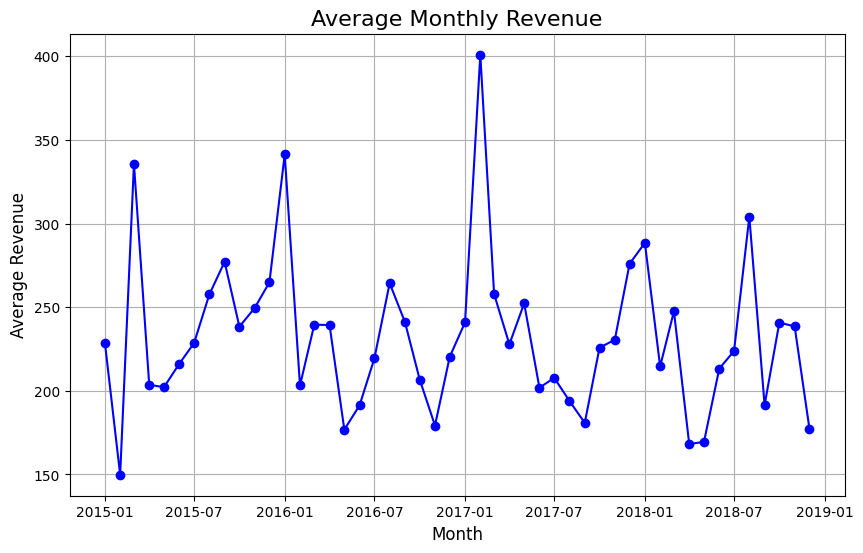

In [13]:
# Convert 'Month' to datetime for better handling
result_df["Month"] = pd.to_datetime(result_df["Month"])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(result_df["Month"], result_df["Average_Revenue"], marker='o', linestyle='-', color='b')
plt.title("Average Monthly Revenue", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Revenue", fontsize=12)
plt.grid(True)

# Save the plot as a PNG file
plt.savefig("average_monthly_revenue.png", dpi=300, bbox_inches="tight")

# Show the plot (optional)
plt.show()

In [58]:
sales_facts_ahmad['Sales'].sum()

np.float64(2252326.0407)

In [56]:
round(sales_facts_ahmad['Sales'], 2).sum()

np.float64(2252325.81)

In [54]:
result

(Decimal('2252326.23'),)

In [42]:
df['Sales'].sum()

np.float64(2252607.4127)

In [46]:
df['Order ID'].nunique()

4916

In [45]:
df.shape

(9789, 18)

In [41]:
fact_query = """
        INSERT INTO Sales_Fact (Order_ID, Date_Key, Ship_Date_Key, Customer_Key, Product_Key, Location_Key, Ship_Mode_Key, Sales)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """
load_df_to_table(fact_query, sales_fact)

Done!
